In [1]:
#!pip3 install xgboost==1.5.2
#!pip install -q condacolab
#import condacolab
#condacolab.install()

#!conda install -c nvidia -c rapidsai -c numba -c conda-forge -c defaults cudf

     |████████████████████████████████| 173.6 MB 9.7 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
print(xgb.__version__)

# This is to supress the warning messages (if any) generated in our code
import warnings
warnings.filterwarnings('ignore')

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

# We are using whitegrid style for our seaborn plots. This is like the most basic one
sns.set_style(style = 'whitegrid')

1.5.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def single_encoding_1(row, useNaN = True):
  ## Disreagard NaNs in logic
  if useNaN:
    if row['death_yn'] == 1 :
      return 'Risk of Death'
    else:
      if row['hosp_yn'] == 1:
        if row['icu_yn'] == 1:
          return 'Hospitalization with ICU'
        else:
          return 'Hospitalization no ICU'
      else:
        return 'No Health Risk'
  ## Get Rid of NaNs      
  else:
    if row['death_yn'] == 1 :
      return 'Risk of Death'
    elif row['death_yn'] == 0: 
      if row['hosp_yn'] == 1:
        if row['icu_yn'] == 1:
          return 'Hospitalization with ICU'
        elif row['icu_yn'] == 0:
          return 'Hospitalization no ICU'
      elif row['hosp_yn'] == 0:
        return 'No Health Risk'


def single_encoding_2(row, useNaN = True):
  if useNaN:
    if row['death_yn'] == 1 :
      if row['icu_yn'] == 1:
        if row['hosp_yn'] == 1:
          return 'Death Risk w Hospitalization and ICU'
        else:
          return 'Death Risk w ICU Need'
      elif row['hosp_yn'] == 1:
        return 'Death Risk w Hospitalization'
      else:
        return 'Death Risk'
    else:
      if row['icu_yn'] == 1:
        if row['hosp_yn'] == 1:
          return 'Bed and ICU Need'
        else:
          return 'ICU Need'
      else:
        if row['hosp_yn'] == 1:
          return 'Hospitalization Risk'
        else:
          return 'No Health Risk'
  else:
    if row['death_yn'] == 1 :
      if row['icu_yn'] == 1:
        if row['hosp_yn'] == 1:
          return 'Death Risk w Hospitalization and ICU'
        elif row['hosp_yn'] == 0:
          return 'Death Risk w ICU Need'
      elif row['hosp_yn'] == 1:
        return 'Death Risk w Hospitalization'
      elif row['hosp_yn'] == 0:
        return 'Death Risk'
    elif row['death_yn'] == 0 :
      if row['icu_yn'] == 1:
        if row['hosp_yn'] == 1:
          return 'Bed and ICU Need'
        elif row['hosp_yn'] == 0:
          return 'ICU Need'
      elif row['icu_yn'] == 0:
        if row['hosp_yn'] == 1:
          return 'Hospitalization Risk'
        elif row['hosp_yn'] == 0:
          return 'No Health Risk'
      


In [4]:
sel_ids = np.random.randint(1,64, 50)
test_inds = [ind for ind in range(64) if ind not in sel_ids]

In [5]:
df = pd.read_csv('/content/drive/MyDrive/CSE6242 Clean Partitions/df_partition_0.csv')
df['Encoding_1'] = df.apply(lambda row: single_encoding_1(row), axis=1)
#df['Encoding_2'] = df.apply(lambda row: single_encoding_2(row), axis=1)

for ind in sel_ids:
  try:
    df_temp = pd.read_csv('/content/drive/MyDrive/CSE6242 Clean Partitions/df_partition_{0}.csv'.format(ind))
    df_temp['Encoding_1'] = df_temp.apply(lambda row: single_encoding_1(row), axis=1)
    #df_temp['Encoding_2'] = df_temp.apply(lambda row: single_encoding_2(row), axis=1)
    df = pd.concat([df,df_temp], axis=0)
  except:
    print("Partition {0} missing".format(ind))

print(df.shape)


(17055676, 78)


In [7]:
#### Get Test Data
startInd = test_inds[0]

df_test = pd.read_csv('/content/drive/MyDrive/CSE6242 Clean Partitions/df_partition_{0}.csv'.format(startInd))
df_test['Encoding_1'] = df_test.apply(lambda row: single_encoding_1(row), axis=1)

for ind in test_inds[1:]:
  try:
    df_temp = pd.read_csv('/content/drive/MyDrive/CSE6242 Clean Partitions/df_partition_{0}.csv'.format(ind))
    df_temp['Encoding_1'] = df_temp.apply(lambda row: single_encoding_1(row), axis=1)
    df_test = pd.concat([df_test,df_temp], axis=0)
  except:
    print("Partition {0} missing".format(ind))

print(df_test.shape)

(9775040, 78)


In [47]:
df_summary = pd.DataFrame()
df_summary['Health Outcome'] = df.groupby('Encoding_1').size().index
df_summary['Train'] = df.groupby('Encoding_1').size().values
df_summary['Test'] = df_test.groupby('Encoding_1').size().values
df_summary['Train'] = df_summary['Train'] / df_summary['Train'].sum() * 100
df_summary['Test'] = df_summary['Test'] / df_summary['Test'].sum() * 100

df_melt = pd.melt(df_summary, id_vars=['Health Outcome'], value_vars=['Train', 'Test'])

sns.set(font_scale = 1.5)
g = sns.catplot(data=df_melt, kind="bar",x="Health Outcome", y="value",
                hue="variable", palette="dark", alpha=.6, height=6,
                legend = False)

g.despine(left=True)
g.set_axis_labels("", "Outcome Percentage (%)", fontsize = 20)
plt.legend(loc='upper right')
#g.legend.set_title("")
plt.gcf().set_size_inches(25, 15)
plt.savefig('/content/drive/MyDrive/CSE6242_Aydin/Figs/category_bars.png')
plt.close()

In [7]:
fit_model = False
if fit_model:
  from xgboost import XGBClassifier

  clf = xgb.XGBClassifier(max_depth=10, objective='multi:softmax',
                          tree_method = 'gpu_hist', n_estimators=500)

  trained_model_1 = clf.fit(df.iloc[:,0:72], df.iloc[:,77])

In [8]:
dump_model = False
if dump_model:
  from joblib import dump
  dump(trained_model_1, "/content/drive/MyDrive/CSE6242_Aydin/model_1_large.joblib")

In [9]:
test_final_model = False

if test_final_model:
  y_train = clf.predict(df.iloc[:,0:72])
  train_df = pd.DataFrame()
  train_df['y'] = df.iloc[:,77]
  train_df['y_pred'] = y_train

  y_test = clf.predict(df_test.iloc[:,0:72])
  test_df = pd.DataFrame()
  test_df['y'] = df_test.iloc[:,77]
  test_df['y_pred'] = y_test

  train_df.to_csv('/content/drive/MyDrive/CSE6242_Aydin/df_train_preds.csv')
  test_df.to_csv('/content/drive/MyDrive/CSE6242_Aydin/df_test_preds.csv')

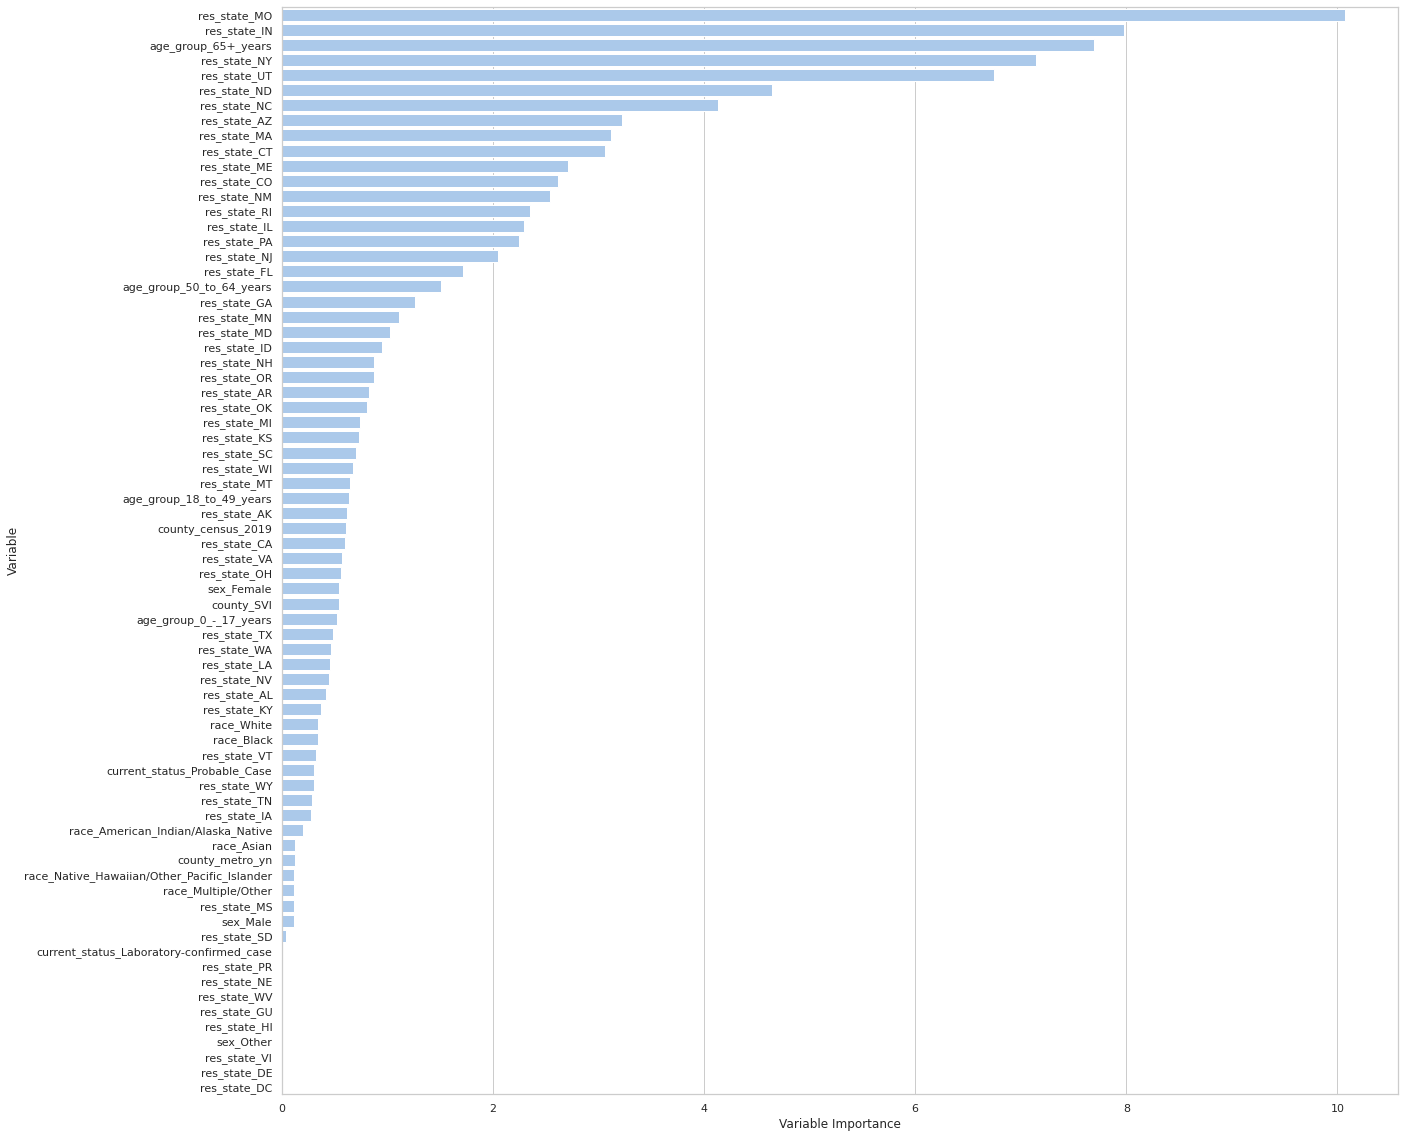

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

#### Sort Variable Importances ####
var_imp = clf.feature_importances_
var_names = [n for n in df_test.iloc[:,0:72].columns]
sort_inds = (-1*var_imp).argsort()
var_names_sorted = [var_names[ind] for ind in sort_inds]
var_imp_sorted = [var_imp[ind] for ind in sort_inds]
var_imp_sorted = [imp/sum(var_imp_sorted) * 100 for imp in var_imp_sorted]

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))
boost_tree_var_imp = pd.DataFrame()
boost_tree_var_imp['Variable'] = var_names_sorted
boost_tree_var_imp['Variable Importance'] = var_imp_sorted

sns.set_color_codes("pastel")
sns.barplot(x='Variable Importance', y='Variable',
            data=boost_tree_var_imp, color="b")
plt.savefig('/content/drive/MyDrive/CSE6242_Aydin/Figs/boosted_var_imp.png')
plt.close()

In [96]:
from sklearn.ensemble import RandomForestClassifier

df = df.dropna()

params = {'max_depth': [2, 5, 10],
        'n_estimators' : [100, 250, 500]}
scoring = {"accuracy", "balanced_accuracy",
           "roc_auc_ovr", "roc_auc_ovo",
           "roc_auc_ovr_weighted", "roc_auc_ovo_weighted"}

rf_model = RandomForestClassifier(random_state = 42)

rf_search = GridSearchCV(estimator = rf_model, param_grid = params, cv = 3, 
                         scoring = scoring, verbose=3, n_jobs = -1, refit = False)

rf_search.fit(df.iloc[:,0:72], df.iloc[:,77])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10],
                         'n_estimators': [100, 250, 500]},
             refit=False,
             scoring={'accuracy', 'balanced_accuracy', 'roc_auc_ovo',
                      'roc_auc_ovo_weighted', 'roc_auc_ovr',
                      'roc_auc_ovr_weighted'},
             verbose=3)

In [101]:
rf_search_df = pd.DataFrame()
rf_search_df['Fit Time(s)'] = rf_search.cv_results_['mean_fit_time']
rf_search_df['Balanced Accuracy'] = rf_search.cv_results_['mean_test_balanced_accuracy']
rf_search_df['Accuracy'] = rf_search.cv_results_['mean_test_accuracy']
rf_search_df['ROC (OVO)'] = rf_search.cv_results_['mean_test_roc_auc_ovo']
rf_search_df['ROC (OVO) Weighted'] = rf_search.cv_results_['mean_test_roc_auc_ovo_weighted']
rf_search_df['ROC (OVR)'] = rf_search.cv_results_['mean_test_roc_auc_ovr']
rf_search_df['ROC (OVR) Weighted'] = rf_search.cv_results_['mean_test_roc_auc_ovr_weighted']

rf_search_df['Max. Depth'] = rf_search.cv_results_['param_max_depth'].data
rf_search_df['Number of Trees'] = rf_search.cv_results_['param_n_estimators'].data

rf_search_df.head()

rf_search_results = pd.melt(rf_search_df, id_vars = ['Max. Depth', 'Number of Trees'],
                           value_vars=['Accuracy', 'ROC (OVO) Weighted', 'ROC (OVR) Weighted'])


In [102]:
sns.lineplot(data=rf_search_results, x='Max. Depth', y='value', hue = 'variable')
plt.savefig('/content/drive/MyDrive/CSE6242_Aydin/Figs/rf_max_depth.png')
plt.close()

sns.lineplot(data=rf_search_results, x='Number of Trees', y='value', hue = 'variable')
plt.savefig('/content/drive/MyDrive/CSE6242_Aydin/Figs/rf_num_tree.png')
plt.close()

In [75]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

params = {'gamma': [1, 1.5, 2, 5],
        'max_depth': [2, 5, 10],
        'n_estimators' : [100, 250, 500]}

scoring = {"accuracy", "balanced_accuracy",
           "roc_auc_ovr", "roc_auc_ovo",
           "roc_auc_ovr_weighted", "roc_auc_ovo_weighted"}

xgbModel = XGBClassifier(objective='multi:softmax', tree_method = 'gpu_hist')

xgb_search = GridSearchCV(estimator = xgbModel, param_grid = params, cv = 3, 
                         scoring = scoring, verbose=3, n_jobs = -1, refit = False)

xgb_search.fit(df.iloc[:,0:72], df.iloc[:,77])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method='gpu_hist',
                                     validate_parameters=N

In [93]:
#xgb_search.cv_results_["params"]
xgb_search_df = pd.DataFrame()
xgb_search_df['Fit Time(s)'] = xgb_search.cv_results_['mean_fit_time']
xgb_search_df['Balanced Accuracy'] = xgb_search.cv_results_['mean_test_balanced_accuracy']
xgb_search_df['Accuracy'] = xgb_search.cv_results_['mean_test_accuracy']
xgb_search_df['ROC (OVO)'] = xgb_search.cv_results_['mean_test_roc_auc_ovo']
xgb_search_df['ROC (OVO) Weighted'] = xgb_search.cv_results_['mean_test_roc_auc_ovo_weighted']
xgb_search_df['ROC (OVR)'] = xgb_search.cv_results_['mean_test_roc_auc_ovr']
xgb_search_df['ROC (OVR) Weighted'] = xgb_search.cv_results_['mean_test_roc_auc_ovr_weighted']
xgb_search_df['Gamma'] = xgb_search.cv_results_['param_gamma'].data
xgb_search_df['Max. Depth'] = xgb_search.cv_results_['param_max_depth'].data
xgb_search_df['Number of Trees'] = xgb_search.cv_results_['param_n_estimators'].data

xgb_search_df.head()

xgb_search_gamma = pd.melt(xgb_search_df, id_vars = ["Gamma", 'Max. Depth', 'Number of Trees'],
                           value_vars=['Accuracy', 'ROC (OVO) Weighted', 'ROC (OVR) Weighted'])


In [95]:
sns.lineplot(data=xgb_search_gamma, x='Gamma', y='value', hue = 'variable')
plt.savefig('/content/drive/MyDrive/CSE6242_Aydin/Figs/xgb_gamma.png')
plt.close()

sns.lineplot(data=xgb_search_gamma, x='Max. Depth', y='value', hue = 'variable')
plt.savefig('/content/drive/MyDrive/CSE6242_Aydin/Figs/xgb_max_depth.png')
plt.close()

sns.lineplot(data=xgb_search_gamma, x='Number of Trees', y='value', hue = 'variable')
plt.savefig('/content/drive/MyDrive/CSE6242_Aydin/Figs/xgb_num_tree.png')
plt.close()

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

scoring = {"accuracy", "balanced_accuracy",
           "roc_auc_ovr", "roc_auc_ovo",
           "roc_auc_ovr_weighted", "roc_auc_ovo_weighted"}

sc_obj = MinMaxScaler(feature_range=(0, 1))
df.iloc[:,71] = sc_obj.fit_transform(np.reshape(df.iloc[:,71].ravel(), (df.iloc[:,71].shape[0], 1) ))

params = [{"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100]},
          {"kernel": ["linear"], "C": [1, 10, 100]}]

svm_search = GridSearchCV(estimator = SVC(), param_grid = params, cv = 3,
                          scoring = scoring, verbose=3, n_jobs = -1,
                          refit = False)

svm_search.fit(df.iloc[:,0:72], df.iloc[:,77])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [ ]:
np.save('/content/drive/MyDrive/CSE6242_Aydin/Figs/svm_search.npy', svm_search)

In [27]:
from sklearn.preprocessing import MinMaxScaler
df_svm = df

sc_obj = MinMaxScaler(feature_range=(0, 1))
df_svm.iloc[:,71] = sc_obj.fit_transform(np.reshape(df.iloc[:,71].ravel(), (df.iloc[:,71].shape[0], 1) ))
df_svm.iloc[:,:71].head()

,current_status_Probable_Case,current_status_Laboratory-confirmed_case,race_White,race_Native_Hawaiian/Other_Pacific_Islander,race_Multiple/Other,race_Black,race_Asian,race_American_Indian/Alaska_Native,sex_Other,sex_Male,...,res_state_DC,res_state_CT,res_state_CO,res_state_CA,res_state_AZ,res_state_AR,res_state_AL,res_state_AK,county_metro_yn,county_SVI
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0


In [ ]:
plotCols  = [col for col in df.columns if col not in df.columns[15:15+54]][:-5]
plotCols.append('Encoding_1')
df_sub = df.loc[:, plotCols]

In [ ]:
import scipy
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

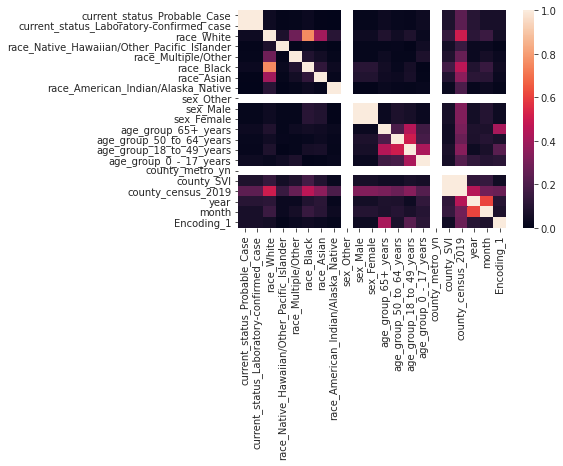

In [ ]:
corrMat = np.zeros((len(plotCols), len(plotCols)))
corrMat
for indX, col1 in enumerate(plotCols):
  for indY, col2 in enumerate(plotCols):
    corrMat[indX, indY] = cramers_v(df_sub[col1], df_sub[col2])

sns.heatmap(corrMat, xticklabels=plotCols, yticklabels=plotCols)